# Import library

packages allowed for use during inference

In [1]:
import os
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms



import imageio.v2 as imageio
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import pandas as pd

from sklearn.manifold import TSNE

packages during training

In [2]:
from thop import profile

# Hyperparameters

In [3]:
BATCH_SIZE = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define Custom Dataset

custom dataset

先計算此training dataset的mean & std (直接用imagenet的)

In [4]:
train_mean = [0.485, 0.456, 0.406]
train_std = [0.229, 0.224, 0.225]

Custom dataset

In [5]:
# dataset整理image & label (from image folder & csv file)
class CustomDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data_frame = pd.read_csv(csv_file) #csv_file : csv file path
        self.root_dir = root_dir #train folder 位置
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data_frame.iloc[idx, 1])
        image = Image.open(img_name).convert("RGB") #image is PIL image
        label = int(self.data_frame.iloc[idx, 2])  # Get the label
        
        if self.transform:
            image = self.transform(image)

        return image, label


建train transform和val transform

val transform和test transform一樣

In [6]:
# Data Transformations
transform_train = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
    transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=train_mean, std=train_std),
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.05), ratio=(0.3, 3.3), value=0)
])

transform_val = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean=train_mean, std=train_std),
])


用P2_train_val_CustomDataset產生custom train & val dataset，再產生trainloader & valloader

In [7]:
train_dataset = CustomDataset(csv_file='../../../hw1_data/p1_data/office/train.csv', root_dir='../../../hw1_data/p1_data/office/train', transform=transform_train)
val_dataset = CustomDataset(csv_file='../../../hw1_data/p1_data/office/val.csv', root_dir='../../../hw1_data/p1_data/office/val', transform=transform_val)

trainloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
valloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [8]:
# print shape
image_first_batch, label_first_batch = next(iter(trainloader))  #get first batch's image & mask
print("type(image_first_batch): ", type(image_first_batch))
print("image_first_batch.shape: ", image_first_batch.shape)
print("type(label_first_batch): ", type(label_first_batch))
print("label_first_batch.shape: ", label_first_batch.shape)

type(image_first_batch):  <class 'torch.Tensor'>
image_first_batch.shape:  torch.Size([128, 3, 128, 128])
type(label_first_batch):  <class 'torch.Tensor'>
label_first_batch.shape:  torch.Size([128])


In [9]:
print(image_first_batch[2][0][100][102])
print(label_first_batch[2])

tensor(1.7352)
tensor(27)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


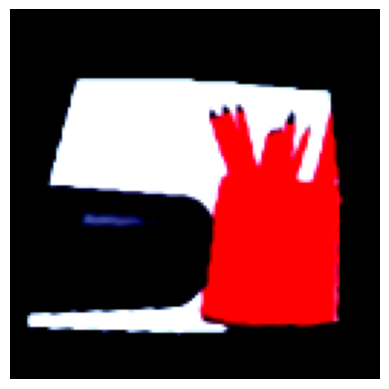

In [10]:
# visualize wo normalization
idx = 1
first_image = image_first_batch[idx]


# Convert the tensor to numpy array
image_np = first_image.numpy()
# Since matplotlib expects images in H x W x C format, we need to transpose it
image_np = np.transpose(image_np, (1, 2, 0))

# Plot the image
plt.imshow(image_np)
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

In [11]:
print(torch.cuda.is_available())

True


# Build Model

instance model
 
A set: 不載入SSL訓練的WEIGHT


In [12]:
backbone = models.resnet50(weights=None)  # No pretrained weights
# Number of input features to the original FC layer
num_features = backbone.fc.in_features  # Typically 2048 for ResNet50 
print(num_features)
backbone.fc = torch.nn.Identity()  # Remove the final classification layer
# A set:
#backbone.load_state_dict(torch.load('../../../checkpoint_model/P1/SSL_pretrain_backbone/best_loss_model.pth'), strict=False) # load the backbone weights

print()

#backbone is on cpu

2048



 **A set:** train full model

 將resnet的fc替換成custom classifier 

In [13]:
# Create CombinedModel with custom classifier
class CombinedModel(nn.Module):
    def __init__(self, Backbone, num_features, hidden1=512, hidden2=256, num_classes=65, dropout_prob=0.5):
        super(CombinedModel, self).__init__()
        #Backbone
        self.Backbone = Backbone
        # First layer
        self.fc1 = nn.Linear(num_features, hidden1)
        self.bn1 = nn.BatchNorm1d(hidden1)  # Batch Normalization for first hidden layer
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=dropout_prob)  # Dropout after first hidden layer

        # Second layer
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.bn2 = nn.BatchNorm1d(hidden2)  # Batch Normalization for second hidden layer
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=dropout_prob)  # Dropout after second hidden layer

        # Final layer (output)
        self.fc3 = nn.Linear(hidden2, num_classes)

    def forward(self, x):
        # Backbone(already replace fc layer by identity)
        x = self.Backbone(x)
        # Forward through the first layer
        x = self.fc1(x)
        x = self.bn1(x)  # Batch normalization
        x = self.relu1(x)
        x = self.dropout1(x)  # Dropout
        
        # Forward through the second layer # Second Last layer(fc layer)
        x = self.fc2(x)
        x = self.bn2(x)  # Batch normalization
        x = self.relu2(x)
        x = self.dropout2(x)  # Dropout

        # Output layer (no activation, used for logits) # Last layer
        x = self.fc3(x)
        return x
    
    def get_second_last_layer_output(self, x):
        # Backbone(already replace fc layer by identity)
        x = self.Backbone(x)
        # Forward through the first layer
        x = self.fc1(x)
        x = self.bn1(x)  # Batch normalization
        x = self.relu1(x)
        x = self.dropout1(x)  # Dropout
        
        # Forward through the second layer (this is where we stop)
        x = self.fc2(x)
        x = self.bn2(x)  # Batch normalization
        x = self.relu2(x)
        x = self.dropout2(x)  # Dropout
        
        # Return the second-to-last layer output
        return x


# Replace the final fully connected layer in ResNet50 with the new MLP head
net = CombinedModel(Backbone=backbone, num_features=num_features)
net = net.to(device)


In [14]:
net.eval()
print(net)
#Compute MACs & params
input1 = torch.randn(1,3,128,128).to(device) # dummy input也放到device
MACs, params = profile(net, inputs=(input1, ))
print('MACs = ' + str(MACs/1000**3) + 'G')
print('Params = ' + str(params/1000**2) + 'M')

CombinedModel(
  (Backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
   

In [15]:
#print output shape
input1 = torch.randn(1,3,128,128).to(device) # dummy input也放到device
output_secondlast = net.get_second_last_layer_output(input1)
output = net(input1)
print(output.shape)
print(output_secondlast.shape)

torch.Size([1, 65])
torch.Size([1, 256])


# Training

Loss and Optimizer and epoch_n

In [16]:
# Loss function with label smoothing
class LabelSmoothingLoss(nn.Module):
    def __init__(self, num_classes, smoothing=0.0):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.num_classes = num_classes

    def forward(self, pred, target):
        # Convert target to one-hot format
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.num_classes - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        
        return torch.mean(torch.sum(-true_dist * torch.log_softmax(pred, dim=1), dim=1))

In [17]:
#criterion = nn.CrossEntropyLoss()
# Create Label Smoothing loss instance
criterion = LabelSmoothingLoss(num_classes=65, smoothing=0.1)
# Initialize optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-4)
# Different base learning rate and update strategy #!!!!!!
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)  #if 5個epoch沒進步==> lr *= 0.5
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.6, last_epoch=-1)
# number of epoch
num_epochs = 100

training & validation loop

In [19]:
# Training and Validation Loop
best_val_acc = 0


for epoch in range(num_epochs):

    net.train() #開啟BN & DROPOUT
    train_loss = 0
    total_train = 0
    correct_train = 0

    for images, targets in tqdm(trainloader, desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch'):  #進度條以batch完成度為趴數
        
        images, targets = images.to(device), targets.to(device)# model, input image, output, mask(target, label, GT) are moved to GPU during training

        optimizer.zero_grad()
        outputs = net(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += targets.size(0) #計算all dataset len
        correct_train += predicted.eq(targets.data).cpu().sum()

    train_loss /= len(trainloader)
    acc1 = correct_train / total_train



    # Validate
    net.eval() #關掉BN & DROPOUT
    val_loss = 0
    total_val = 0
    correct_val = 0

    with torch.no_grad():
        for images, targets in tqdm(valloader, desc='Validation', unit='batch'):
            images, targets = images.to(device), targets.to(device)

            outputs = net(images)  #(bs, 7, 512, 512)
            loss = criterion(outputs, targets) 


            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += targets.size(0) #計算all dataset len
            correct_val += predicted.eq(targets.data).cpu().sum()

    
    val_loss /= len(valloader)
    acc2 = correct_val / total_val
    
    # Save best model
    if acc2 > best_val_acc:
        best_val_acc = acc2
        #torch.save(net.state_dict(), os.path.join("../../../", "checkpoint_model", "P1", "Fine_tune", "A", "best_val_acc_model.pth")) # only C set need to save the model
        print(f'best model update,  val acc: {acc2:.4f}')


    scheduler.step(acc2)


    # Logging
    print(f'Epoch {epoch + 1}/{num_epochs} - Train Loss: {train_loss:.4f} - Train acc: {acc1:.4f} - Val Loss: {val_loss:.4f} - Val acc: {acc2:.4f}')
    print(f'Learning rate: {scheduler.get_last_lr()[0]}')

Validation: 100%|██████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.53s/batch]


best model update,  val acc: 0.0320
Epoch 1/100 - Train Loss: 4.2092 - Train acc: 0.0248 - Val Loss: 4.1480 - Val acc: 0.0320
Learning rate: 0.001


Validation: 100%|██████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.53s/batch]


best model update,  val acc: 0.0493
Epoch 2/100 - Train Loss: 4.1925 - Train acc: 0.0296 - Val Loss: 4.0769 - Val acc: 0.0493
Learning rate: 0.001


Validation: 100%|██████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.53s/batch]


Epoch 3/100 - Train Loss: 4.1730 - Train acc: 0.0271 - Val Loss: 4.0714 - Val acc: 0.0369
Learning rate: 0.001


Validation: 100%|██████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.55s/batch]


Epoch 4/100 - Train Loss: 4.1358 - Train acc: 0.0268 - Val Loss: 4.0054 - Val acc: 0.0443
Learning rate: 0.001


Validation: 100%|██████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.55s/batch]


best model update,  val acc: 0.0616
Epoch 5/100 - Train Loss: 4.1036 - Train acc: 0.0415 - Val Loss: 4.0003 - Val acc: 0.0616
Learning rate: 0.001


Validation: 100%|██████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.53s/batch]


Epoch 6/100 - Train Loss: 4.0635 - Train acc: 0.0466 - Val Loss: 3.9508 - Val acc: 0.0517
Learning rate: 0.001


Validation: 100%|██████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.53s/batch]


Epoch 7/100 - Train Loss: 4.0098 - Train acc: 0.0597 - Val Loss: 3.8984 - Val acc: 0.0616
Learning rate: 0.001


Validation: 100%|██████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.53s/batch]


best model update,  val acc: 0.0739
Epoch 8/100 - Train Loss: 3.9838 - Train acc: 0.0559 - Val Loss: 4.0000 - Val acc: 0.0739
Learning rate: 0.001


Validation: 100%|██████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.53s/batch]


best model update,  val acc: 0.0887
Epoch 9/100 - Train Loss: 3.9424 - Train acc: 0.0688 - Val Loss: 3.8471 - Val acc: 0.0887
Learning rate: 0.001


Validation: 100%|██████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.54s/batch]


Epoch 10/100 - Train Loss: 3.9234 - Train acc: 0.0767 - Val Loss: 3.9213 - Val acc: 0.0764
Learning rate: 0.001


Validation: 100%|██████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.52s/batch]


Epoch 11/100 - Train Loss: 3.8997 - Train acc: 0.0825 - Val Loss: 3.8588 - Val acc: 0.0887
Learning rate: 0.001


Validation: 100%|██████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.58s/batch]


Epoch 12/100 - Train Loss: 3.8671 - Train acc: 0.0818 - Val Loss: 3.8824 - Val acc: 0.0788
Learning rate: 0.001


Validation: 100%|██████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.62s/batch]


best model update,  val acc: 0.0985
Epoch 13/100 - Train Loss: 3.8478 - Train acc: 0.0843 - Val Loss: 3.7662 - Val acc: 0.0985
Learning rate: 0.001


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.54s/batch]


best model update,  val acc: 0.1034
Epoch 15/100 - Train Loss: 3.7976 - Train acc: 0.0995 - Val Loss: 3.7290 - Val acc: 0.1034
Learning rate: 0.001


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.54s/batch]


best model update,  val acc: 0.1059
Epoch 16/100 - Train Loss: 3.7842 - Train acc: 0.1116 - Val Loss: 3.6356 - Val acc: 0.1059
Learning rate: 0.001


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [03:27<00:00, 51.94s/batch]


best model update,  val acc: 0.1207
Epoch 17/100 - Train Loss: 3.7424 - Train acc: 0.1045 - Val Loss: 3.7054 - Val acc: 0.1207
Learning rate: 0.001


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.52s/batch]


best model update,  val acc: 0.1256
Epoch 18/100 - Train Loss: 3.7075 - Train acc: 0.1212 - Val Loss: 3.6748 - Val acc: 0.1256
Learning rate: 0.001


Validation: 100%|█████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.54s/batch]


Epoch 23/100 - Train Loss: 3.5602 - Train acc: 0.1455 - Val Loss: 3.6685 - Val acc: 0.1207
Learning rate: 0.001


Validation: 100%|█████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.54s/batch]


best model update,  val acc: 0.1749
Epoch 24/100 - Train Loss: 3.5426 - Train acc: 0.1607 - Val Loss: 3.4462 - Val acc: 0.1749
Learning rate: 0.001


Validation: 100%|█████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.54s/batch]


best model update,  val acc: 0.1946
Epoch 25/100 - Train Loss: 3.5280 - Train acc: 0.1655 - Val Loss: 3.4764 - Val acc: 0.1946
Learning rate: 0.001


Validation: 100%|█████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.56s/batch]


Epoch 26/100 - Train Loss: 3.4810 - Train acc: 0.1721 - Val Loss: 3.9429 - Val acc: 0.1256
Learning rate: 0.001


Validation: 100%|█████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.56s/batch]


Epoch 27/100 - Train Loss: 3.4522 - Train acc: 0.1858 - Val Loss: 3.6823 - Val acc: 0.1404
Learning rate: 0.001


Validation: 100%|█████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.55s/batch]


best model update,  val acc: 0.2143
Epoch 28/100 - Train Loss: 3.4339 - Train acc: 0.1838 - Val Loss: 3.3953 - Val acc: 0.2143
Learning rate: 0.001


Validation: 100%|█████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.55s/batch]


Epoch 29/100 - Train Loss: 3.3713 - Train acc: 0.2015 - Val Loss: 3.4428 - Val acc: 0.2020
Learning rate: 0.001


Validation: 100%|█████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.56s/batch]


Epoch 30/100 - Train Loss: 3.3546 - Train acc: 0.2045 - Val Loss: 3.3843 - Val acc: 0.2118
Learning rate: 0.001


Validation: 100%|█████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.53s/batch]


Epoch 31/100 - Train Loss: 3.3372 - Train acc: 0.2182 - Val Loss: 3.4244 - Val acc: 0.1552
Learning rate: 0.001


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.54s/batch]


Epoch 32/100 - Train Loss: 3.2989 - Train acc: 0.2194 - Val Loss: 3.3745 - Val acc: 0.1773
Learning rate: 0.001


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.53s/batch]


best model update,  val acc: 0.2241
Epoch 33/100 - Train Loss: 3.2863 - Train acc: 0.2177 - Val Loss: 3.1834 - Val acc: 0.2241
Learning rate: 0.001


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.55s/batch]


Epoch 34/100 - Train Loss: 3.2276 - Train acc: 0.2384 - Val Loss: 3.2248 - Val acc: 0.2241
Learning rate: 0.001


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.53s/batch]


Epoch 35/100 - Train Loss: 3.2099 - Train acc: 0.2435 - Val Loss: 3.2304 - Val acc: 0.2217
Learning rate: 0.001


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.53s/batch]


Epoch 36/100 - Train Loss: 3.1898 - Train acc: 0.2503 - Val Loss: 3.3185 - Val acc: 0.2192
Learning rate: 0.001


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.56s/batch]


Epoch 37/100 - Train Loss: 3.1482 - Train acc: 0.2564 - Val Loss: 3.2953 - Val acc: 0.2118
Learning rate: 0.001


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.54s/batch]


best model update,  val acc: 0.2734
Epoch 38/100 - Train Loss: 3.1432 - Train acc: 0.2506 - Val Loss: 3.0366 - Val acc: 0.2734
Learning rate: 0.001


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.55s/batch]


Epoch 39/100 - Train Loss: 3.0845 - Train acc: 0.2822 - Val Loss: 3.3079 - Val acc: 0.2512
Learning rate: 0.001


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.56s/batch]


best model update,  val acc: 0.3054
Epoch 40/100 - Train Loss: 3.1226 - Train acc: 0.2594 - Val Loss: 3.1075 - Val acc: 0.3054
Learning rate: 0.001


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.57s/batch]


Epoch 41/100 - Train Loss: 3.0845 - Train acc: 0.2673 - Val Loss: 3.3085 - Val acc: 0.2192
Learning rate: 0.001


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.56s/batch]


Epoch 42/100 - Train Loss: 3.0628 - Train acc: 0.2736 - Val Loss: 3.0664 - Val acc: 0.2562
Learning rate: 0.001


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.57s/batch]


Epoch 43/100 - Train Loss: 3.0023 - Train acc: 0.3030 - Val Loss: 2.9925 - Val acc: 0.2783
Learning rate: 0.001


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.54s/batch]


Epoch 44/100 - Train Loss: 3.0088 - Train acc: 0.2938 - Val Loss: 3.1371 - Val acc: 0.2488
Learning rate: 0.001


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.54s/batch]


best model update,  val acc: 0.3153
Epoch 45/100 - Train Loss: 2.9771 - Train acc: 0.2987 - Val Loss: 2.9856 - Val acc: 0.3153
Learning rate: 0.001


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.54s/batch]


Epoch 46/100 - Train Loss: 2.9511 - Train acc: 0.3098 - Val Loss: 3.1980 - Val acc: 0.2463
Learning rate: 0.001


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.56s/batch]


Epoch 47/100 - Train Loss: 2.9622 - Train acc: 0.3116 - Val Loss: 2.9712 - Val acc: 0.2808
Learning rate: 0.001


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.57s/batch]


Epoch 48/100 - Train Loss: 2.9250 - Train acc: 0.3222 - Val Loss: 2.9719 - Val acc: 0.3103
Learning rate: 0.001


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.56s/batch]


best model update,  val acc: 0.3227
Epoch 49/100 - Train Loss: 2.9013 - Train acc: 0.3176 - Val Loss: 2.9445 - Val acc: 0.3227
Learning rate: 0.001


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.54s/batch]


Epoch 50/100 - Train Loss: 2.8745 - Train acc: 0.3361 - Val Loss: 3.0216 - Val acc: 0.2537
Learning rate: 0.001


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.54s/batch]


Epoch 51/100 - Train Loss: 2.8325 - Train acc: 0.3473 - Val Loss: 3.0815 - Val acc: 0.2906
Learning rate: 0.001


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.54s/batch]


Epoch 52/100 - Train Loss: 2.8212 - Train acc: 0.3414 - Val Loss: 2.8949 - Val acc: 0.3030
Learning rate: 0.001


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.55s/batch]


best model update,  val acc: 0.3325
Epoch 53/100 - Train Loss: 2.8330 - Train acc: 0.3412 - Val Loss: 2.9600 - Val acc: 0.3325
Learning rate: 0.001


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.54s/batch]


Epoch 54/100 - Train Loss: 2.7864 - Train acc: 0.3670 - Val Loss: 3.0145 - Val acc: 0.3103
Learning rate: 0.001


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.55s/batch]


Epoch 55/100 - Train Loss: 2.7585 - Train acc: 0.3685 - Val Loss: 3.1512 - Val acc: 0.2709
Learning rate: 0.001


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.55s/batch]


Epoch 56/100 - Train Loss: 2.7593 - Train acc: 0.3736 - Val Loss: 2.8868 - Val acc: 0.3128
Learning rate: 0.001


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.54s/batch]


Epoch 57/100 - Train Loss: 2.7281 - Train acc: 0.3693 - Val Loss: 2.9624 - Val acc: 0.3325
Learning rate: 0.001


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.56s/batch]


Epoch 58/100 - Train Loss: 2.7041 - Train acc: 0.3797 - Val Loss: 3.2113 - Val acc: 0.2931
Learning rate: 0.001


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.54s/batch]


best model update,  val acc: 0.3350
Epoch 59/100 - Train Loss: 2.7096 - Train acc: 0.3847 - Val Loss: 2.9234 - Val acc: 0.3350
Learning rate: 0.001


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.54s/batch]


Epoch 60/100 - Train Loss: 2.6650 - Train acc: 0.3900 - Val Loss: 3.1551 - Val acc: 0.2635
Learning rate: 0.001


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.56s/batch]


best model update,  val acc: 0.3621
Epoch 61/100 - Train Loss: 2.6451 - Train acc: 0.3956 - Val Loss: 2.8218 - Val acc: 0.3621
Learning rate: 0.001


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.55s/batch]


best model update,  val acc: 0.3966
Epoch 62/100 - Train Loss: 2.6198 - Train acc: 0.3956 - Val Loss: 2.7757 - Val acc: 0.3966
Learning rate: 0.001


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.56s/batch]


Epoch 63/100 - Train Loss: 2.6179 - Train acc: 0.4080 - Val Loss: 3.3294 - Val acc: 0.2635
Learning rate: 0.001


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.54s/batch]


Epoch 64/100 - Train Loss: 2.5913 - Train acc: 0.4083 - Val Loss: 2.8509 - Val acc: 0.3473
Learning rate: 0.001


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.54s/batch]


Epoch 65/100 - Train Loss: 2.5413 - Train acc: 0.4341 - Val Loss: 2.7090 - Val acc: 0.3842
Learning rate: 0.001


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.55s/batch]


Epoch 66/100 - Train Loss: 2.5382 - Train acc: 0.4252 - Val Loss: 2.7245 - Val acc: 0.3719
Learning rate: 0.001


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.56s/batch]


Epoch 67/100 - Train Loss: 2.5333 - Train acc: 0.4308 - Val Loss: 2.7805 - Val acc: 0.3645
Learning rate: 0.001


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.54s/batch]


Epoch 68/100 - Train Loss: 2.5209 - Train acc: 0.4331 - Val Loss: 2.7809 - Val acc: 0.3695
Learning rate: 0.0005


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.55s/batch]


best model update,  val acc: 0.4187
Epoch 69/100 - Train Loss: 2.3885 - Train acc: 0.4705 - Val Loss: 2.5774 - Val acc: 0.4187
Learning rate: 0.0005


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.55s/batch]


Epoch 70/100 - Train Loss: 2.3267 - Train acc: 0.5032 - Val Loss: 2.5537 - Val acc: 0.4113
Learning rate: 0.0005


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.56s/batch]


Epoch 71/100 - Train Loss: 2.2908 - Train acc: 0.5123 - Val Loss: 2.7207 - Val acc: 0.4064
Learning rate: 0.0005


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.55s/batch]


best model update,  val acc: 0.4286
Epoch 72/100 - Train Loss: 2.2358 - Train acc: 0.5287 - Val Loss: 2.5571 - Val acc: 0.4286
Learning rate: 0.0005


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.56s/batch]


Epoch 73/100 - Train Loss: 2.2362 - Train acc: 0.5221 - Val Loss: 2.6058 - Val acc: 0.4113
Learning rate: 0.0005


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.54s/batch]


Epoch 74/100 - Train Loss: 2.2071 - Train acc: 0.5406 - Val Loss: 2.5473 - Val acc: 0.3966
Learning rate: 0.0005


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.56s/batch]


best model update,  val acc: 0.4557
Epoch 75/100 - Train Loss: 2.1905 - Train acc: 0.5318 - Val Loss: 2.5277 - Val acc: 0.4557
Learning rate: 0.0005


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.55s/batch]


Epoch 76/100 - Train Loss: 2.1876 - Train acc: 0.5389 - Val Loss: 2.5806 - Val acc: 0.4483
Learning rate: 0.0005


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.55s/batch]


Epoch 77/100 - Train Loss: 2.1655 - Train acc: 0.5505 - Val Loss: 2.6517 - Val acc: 0.4212
Learning rate: 0.0005


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.55s/batch]


Epoch 78/100 - Train Loss: 2.1308 - Train acc: 0.5662 - Val Loss: 2.5564 - Val acc: 0.4113
Learning rate: 0.0005


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.55s/batch]


Epoch 79/100 - Train Loss: 2.1130 - Train acc: 0.5712 - Val Loss: 2.6359 - Val acc: 0.4089
Learning rate: 0.0005


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.56s/batch]


Epoch 80/100 - Train Loss: 2.1041 - Train acc: 0.5720 - Val Loss: 2.4852 - Val acc: 0.4433
Learning rate: 0.0005


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.55s/batch]


Epoch 81/100 - Train Loss: 2.0933 - Train acc: 0.5735 - Val Loss: 2.5665 - Val acc: 0.4064
Learning rate: 0.00025


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.55s/batch]


Epoch 82/100 - Train Loss: 2.0063 - Train acc: 0.6067 - Val Loss: 2.5161 - Val acc: 0.4433
Learning rate: 0.00025


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.55s/batch]


best model update,  val acc: 0.4581
Epoch 83/100 - Train Loss: 1.9679 - Train acc: 0.6196 - Val Loss: 2.4639 - Val acc: 0.4581
Learning rate: 0.00025


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.55s/batch]


best model update,  val acc: 0.4680
Epoch 84/100 - Train Loss: 1.9118 - Train acc: 0.6424 - Val Loss: 2.4134 - Val acc: 0.4680
Learning rate: 0.00025


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.54s/batch]


Epoch 85/100 - Train Loss: 1.8756 - Train acc: 0.6530 - Val Loss: 2.4565 - Val acc: 0.4581
Learning rate: 0.00025


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.55s/batch]


Epoch 86/100 - Train Loss: 1.8508 - Train acc: 0.6629 - Val Loss: 2.4428 - Val acc: 0.4483
Learning rate: 0.00025


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.54s/batch]


best model update,  val acc: 0.4778
Epoch 87/100 - Train Loss: 1.8452 - Train acc: 0.6586 - Val Loss: 2.5173 - Val acc: 0.4778
Learning rate: 0.00025


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.54s/batch]


best model update,  val acc: 0.4877
Epoch 88/100 - Train Loss: 1.8499 - Train acc: 0.6659 - Val Loss: 2.3739 - Val acc: 0.4877
Learning rate: 0.00025


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.55s/batch]


Epoch 89/100 - Train Loss: 1.8148 - Train acc: 0.6758 - Val Loss: 2.4949 - Val acc: 0.4778
Learning rate: 0.00025


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.55s/batch]


Epoch 90/100 - Train Loss: 1.8078 - Train acc: 0.6778 - Val Loss: 2.5292 - Val acc: 0.4384
Learning rate: 0.00025


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.55s/batch]


Epoch 91/100 - Train Loss: 1.8036 - Train acc: 0.6831 - Val Loss: 2.4170 - Val acc: 0.4704
Learning rate: 0.00025


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.54s/batch]


Epoch 92/100 - Train Loss: 1.7622 - Train acc: 0.6993 - Val Loss: 2.4790 - Val acc: 0.4581
Learning rate: 0.00025


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.54s/batch]


Epoch 93/100 - Train Loss: 1.7467 - Train acc: 0.7029 - Val Loss: 2.4694 - Val acc: 0.4581
Learning rate: 0.00025


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.55s/batch]


best model update,  val acc: 0.4901
Epoch 94/100 - Train Loss: 1.7295 - Train acc: 0.7031 - Val Loss: 2.4576 - Val acc: 0.4901
Learning rate: 0.00025


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.56s/batch]


Epoch 95/100 - Train Loss: 1.7188 - Train acc: 0.7117 - Val Loss: 2.4522 - Val acc: 0.4803
Learning rate: 0.00025


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.55s/batch]


Epoch 96/100 - Train Loss: 1.7224 - Train acc: 0.7016 - Val Loss: 2.4624 - Val acc: 0.4557
Learning rate: 0.00025


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.54s/batch]


Epoch 97/100 - Train Loss: 1.7240 - Train acc: 0.7031 - Val Loss: 2.4729 - Val acc: 0.4557
Learning rate: 0.00025


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.56s/batch]


Epoch 98/100 - Train Loss: 1.6921 - Train acc: 0.7173 - Val Loss: 2.4657 - Val acc: 0.4754
Learning rate: 0.00025


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.55s/batch]


Epoch 99/100 - Train Loss: 1.7101 - Train acc: 0.7201 - Val Loss: 2.6693 - Val acc: 0.4089
Learning rate: 0.00025


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.55s/batch]

Epoch 100/100 - Train Loss: 1.6763 - Train acc: 0.7231 - Val Loss: 2.5660 - Val acc: 0.4655
Learning rate: 0.000125


In [20]:
print(best_val_acc)

tensor(0.4901)
